In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.stats as stats
# # 
import warnings
# 
# import arviz as az
# import pymc as pm
# import theano.tensor as tt

In [2]:
class A_dist():
    def __init__(self, beta_hat = None):
        self.beta = 1 if beta_hat == None else beta_hat
        # self.beta_hat = 0
        self.df = pd.DataFrame(columns = ['beta', 'beta_hat', 'sample_size', 'initial_guess'])
    
    def pdf(self, x):
        if(x <= 0): return 0
            
        c = self.beta/x
        if(c > 10): return 0
        pdf = (x**-2) * np.exp(((1 - np.exp(c))/self.beta) + c)

        return pdf

        
    def cdf(self, x):
        if(x <= 0): return 0

        c = self.beta/x
        if(c > 10): return 0
        # cdf = np.exp((1 - np.exp(c))/self.beta)
        log_cdf = (1 - np.exp(c))/(self.beta)
        return np.exp(log_cdf)
    
    def cdf_call(self, x):
        result = np.zeros_like(x)
        mask_positive = x > 0

        c = self.beta / x[mask_positive]
        log_cdf = (1 - np.exp(c)) / self.beta
        result[mask_positive] = np.exp(log_cdf)
        return result

        
    def plot(self):
        fig, axs = plt.subplots(1, 2, figsize=(15,7))
        tolerance = 10**-2

        ax = axs[0]

        x = np.linspace(10**-5, 30, 1000)     
        ax.plot(x, [self.pdf(value) for value in x])
        ax.set_title('PDF')
        
        ax = axs[1]
        lim_sup = 1
        while((1 - self.cdf(lim_sup)) > tolerance): lim_sup+=1
    
        x = np.linspace(10**-5, lim_sup, 1000)     
        ax.plot(x, [self.cdf(value) for value in x])
        ax.set_title('CDF')
        plt.show()
        
    
    def MLE(self, x_values, **kwargs):
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)
    
        result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)

        while result[0] < 0:
            x_values = self.exp_sample(n = len(x_values))
            result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)

        return result[0]
    
    def LL(self, x_values, **kwargs):
        beta_hat = kwargs['beta_hat']

        sum_X =   sum(x**-1 for x in x_values)
        sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
        sum_ln = sum(np.log(x) for x in x_values)
        return (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)


    def exp_sample(self, n = 10):
        x = []
        for i in range(n):
            u = np.random.random()
            value = self.beta/np.log(1 - (self.beta* np.log(u)))
            while(value > 100):
                u = np.random.random()
                value = self.beta/np.log(1 - (self.beta* np.log(u)))
            x.append(value)
        return x

    def plot_sample(self, n = 10, lim_sup = 100, **kwargs):
        sample = self.exp_sample(n = n)
        fig, ax = plt.subplots(1, 1, figsize=(15,7))
        
        plt.hist(sample, bins = int(n/2), density=True, alpha=0.5, color='blue', label='Generated Data')
        # lim_sup = max(sample)

        x = np.linspace(0, lim_sup, 1000)
        pdf = [self.pdf(value) for value in x]
        
        plt.plot(x, pdf, color='red', label='Theoretical PDF')
        
        ax.set_xlim(0,100)
        plt.xlabel('Random Variable')
        plt.ylabel('Probability Density')
        plt.title('Random Variables using Inverse Transformation')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        beta_hat = self.MLE(x_values = sample, **kwargs)
        print(f"Valor estimado para beta:{beta_hat:.2f}")
        
        return sample

    def run_experiment(self, true_params : list, sample_sizes : list, n_rep : int, initial_guess : list):
        for param in true_params:
            self.beta = param
            for sample_size in sample_sizes:
                for guess in initial_guess:
                    for rep in range(n_rep):
                        sample = self.exp_sample(n = sample_size)
                        beta_hat = self.MLE(x_values = sample, initial_guess = guess)
                        self.df.loc[len(self.df)] = [param, beta_hat, sample_size, guess]
    

    def plot_experiment(self, true_param, applyGap = True):
        fig, axs = plt.subplots(1, 2, figsize = (15,7))
        result = self.df.loc[self.df['beta'] == true_param]
        result = result.groupby(['sample_size', 'initial_guess'])['beta_hat'].agg(['mean', 'std']).reset_index()
        
        ax = axs[1]
        for i, guess in enumerate(result['initial_guess'].unique()):
            # data = result.loc[(result['initial_guess'] == guess) & (result['beta'] == true_param)]     
            data = result.loc[(result['initial_guess'] == guess)]  
            plt.errorbar(data['sample_size'] + i*(5 if applyGap else 0), data['mean'], yerr=data['std'], fmt='-o', capsize=5, label = guess)
        
        ax.legend()
        ax.set_title(f"Estimation of the Beta parameter - True value = {true_param}")
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Beta_hat')
        
        ax = axs[0]
        ax = fig.add_subplot(121, projection='3d')
        for i, guess in enumerate(result['initial_guess'].unique()):
            data = result.loc[(result['initial_guess'] == guess)]
            ax.plot(data['sample_size'], [guess] * len(data), data['mean'], label=f'Initial Guess {guess}', marker='o')
    
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Initial Guess')
        ax.set_zlabel('Beta_hat')
        ax.legend()
    
        # ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_title(f"Estimation of the Beta parameter - True value = {true_param}")
        plt.tight_layout()
        plt.show()

# Simulação

In [3]:
rep = 1000
initial_guess = [0.75, 1, 1.5, 2]

a = A_dist()
a.run_experiment(true_params = [0.125, 0.60, 1], sample_sizes = [20, 50, 100,  400], initial_guess=initial_guess, n_rep = rep)

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


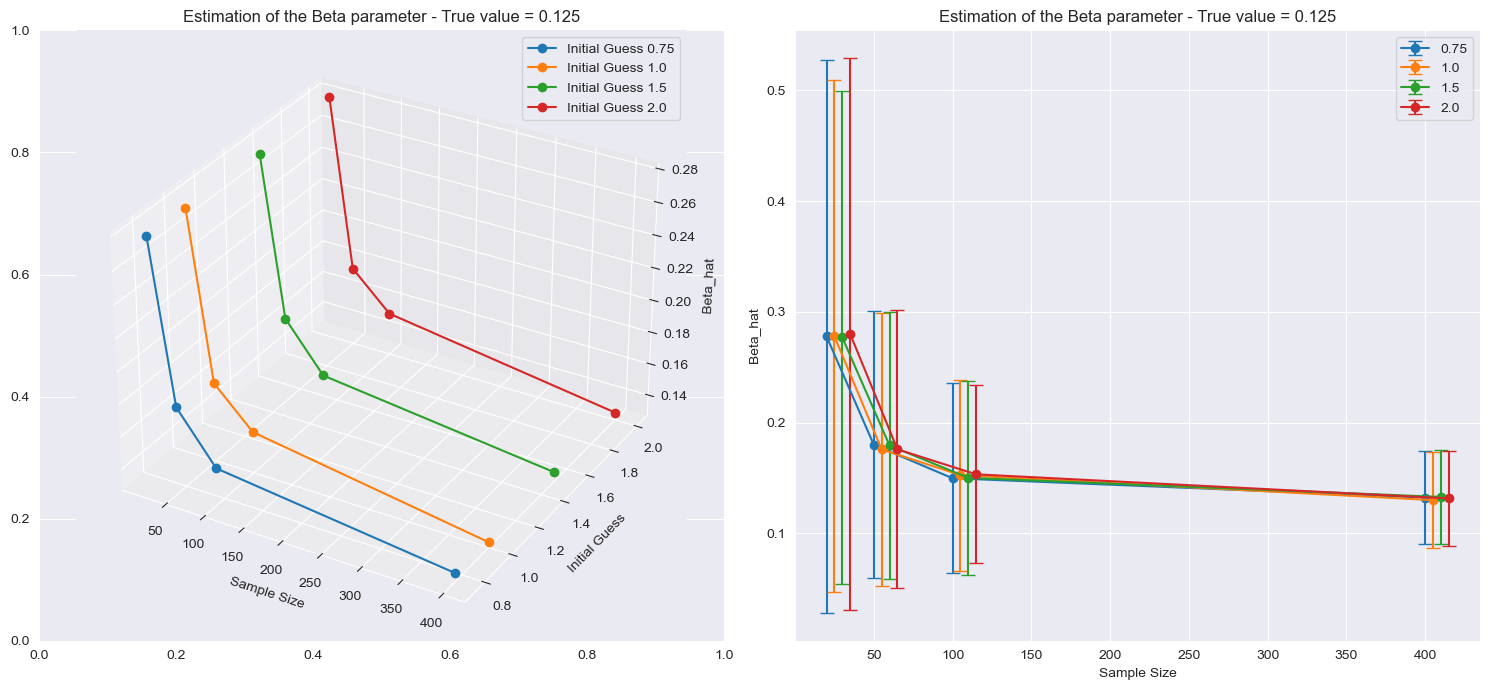

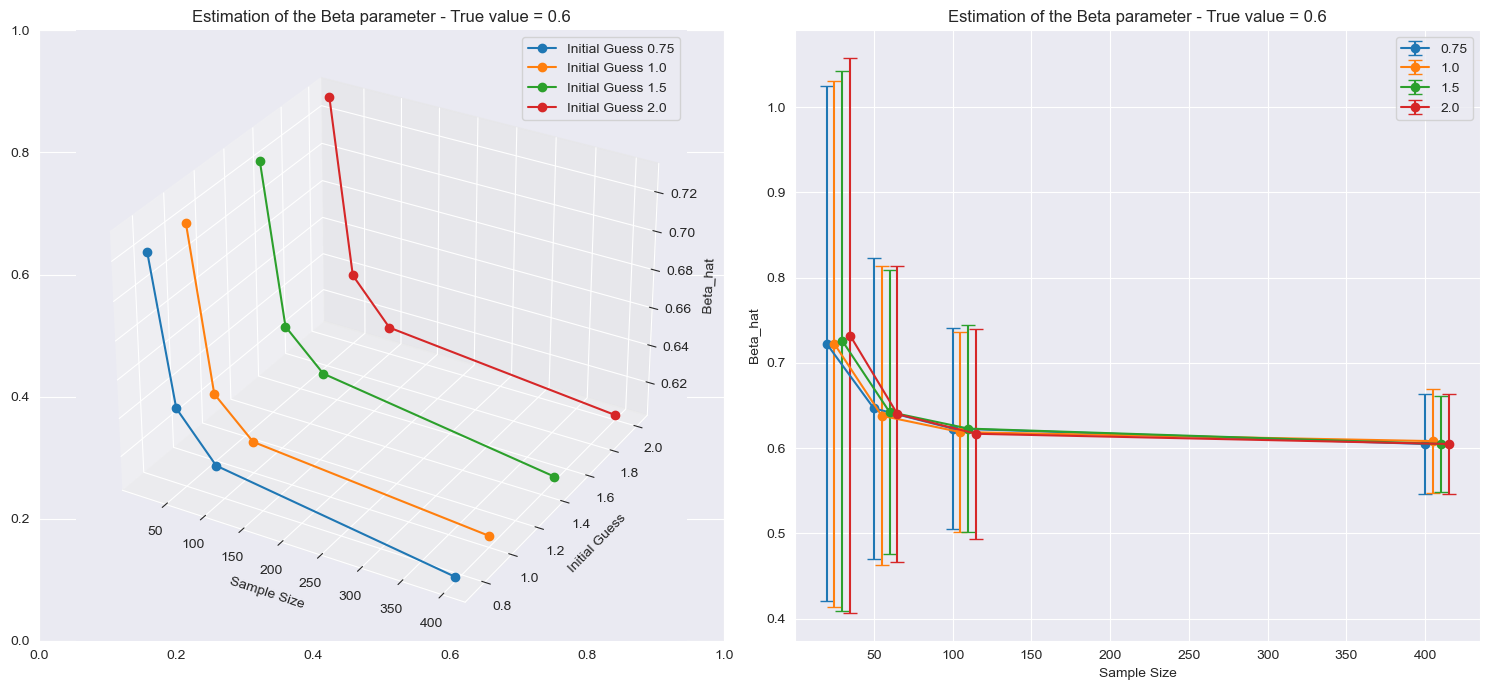

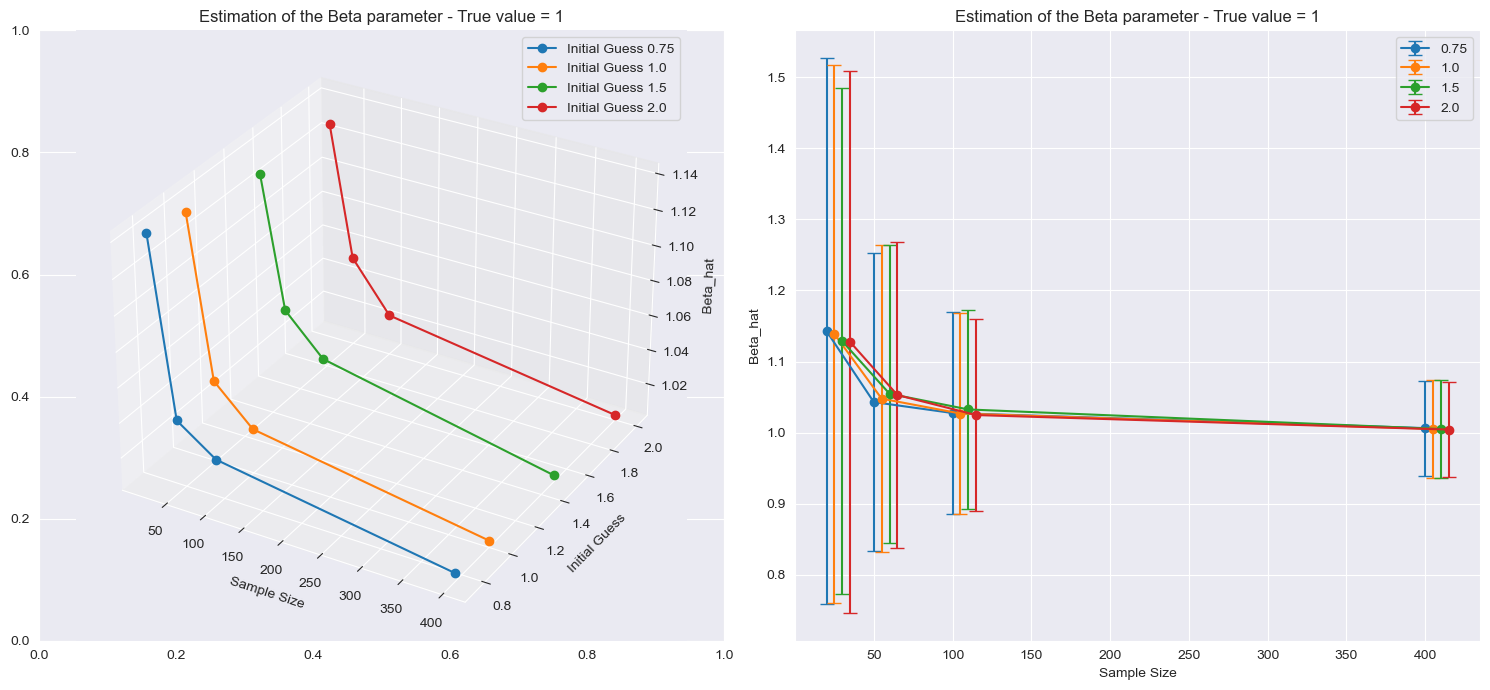

In [4]:
a.plot_experiment(true_param = 0.125)
a.plot_experiment(true_param = 0.60)
a.plot_experiment(true_param = 1)

In [5]:
df_teste = a.df.copy()
df_teste['mse'] = (df_teste['beta'] - df_teste['beta_hat'])**2

mse_sum = df_teste.groupby(['initial_guess', 'sample_size', 'beta' ])['mse'].sum()
mse_sum = mse_sum.drop(columns = 'initial_guess').groupby(['sample_size', 'beta']).sum() / (rep * len(initial_guess))

grouped = df_teste.groupby(['sample_size', 'beta'])['beta_hat'].agg(['mean', 'std', 'var']).reset_index()

result = pd.merge(grouped, mse_sum, on=['sample_size', 'beta'])
result['bias'] = abs(result['beta'] - result['mean'])
result.head(15)

,sample_size,beta,mean,std,var,mse,bias
0,20.0,0.125,0.278234,0.238252,0.056764,0.080230,0.153234
1,20.0,0.600,0.725685,0.313266,0.098136,0.113908,0.125685
2,20.0,1.000,1.134448,0.375092,0.140694,0.158735,0.134448
3,50.0,0.125,0.177766,0.122440,0.014991,0.017772,0.052766
4,50.0,0.600,0.641687,0.173247,0.030015,0.031745,0.041687
5,50.0,1.000,1.049642,0.212563,0.045183,0.047636,0.049642
6,100.0,0.125,0.151490,0.084873,0.007203,0.007903,0.026490
7,100.0,0.600,0.620332,0.120260,0.014462,0.014872,0.020332
8,100.0,1.000,1.027990,0.139640,0.019499,0.020278,0.027990
9,400.0,0.125,0.131730,0.042641,0.001818,0.001863,0.006730


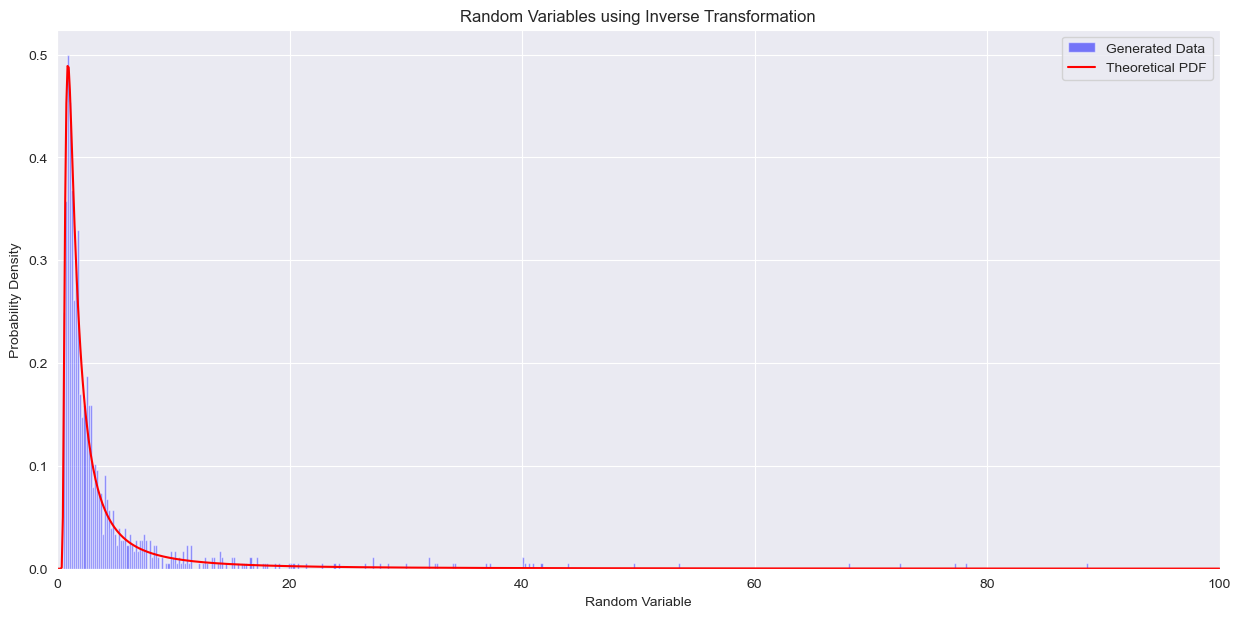

Valor estimado para beta:0.99


(1000, 88.64993963648642)

In [6]:
x = a.plot_sample(n=1000, lim_sup=100, initial_guess = 100)
len(x), max(x)

# Amostra real

In [7]:
def A_distribution(x_values, **kwargs):
    
    def MLE_A(x_values, **kwargs):
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)
    
        result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)
        return result[0]
    
    def LL_A(x_values, **kwargs):
        beta_hat = kwargs['beta_hat']
    
        sum_X =   sum(x**-1 for x in x_values)
        sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
        sum_ln = sum(np.log(x) for x in x_values)
        return (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)
    
    results_mle = []
    results_ll = []
    # Caso que envolve resolução por métodos numéricos - vários tamanhos de passos/repetições para checar convergência
    for i in range(1, 1000, 100):
        for j in range(5):
            results_mle.append(MLE_A(sample_real, initial_guess = i))
            b_hat = sum(results_mle) / len(results_mle)
            results_ll.append(LL_A(sample_real, beta_hat = b_hat))  
            
    # Checando a diferença máxima entro os valores gerados:
    tol = 1e-7
    diff_mle = 0
    diff_ll = 0
    for i in range(len(results_mle)):
        for j in range(i + 1, len(results_mle)):
            diff = abs(results_mle[i] - results_mle[j])
            if diff > diff_mle:
                diff_mle = diff
                
            diff = abs(results_ll[i] - results_ll[j])
            if diff > diff_ll:
                diff_ll = diff

    if (diff_mle > tol) or (diff_ll > tol):
        print("Erro de convergência!\nFunção abortada!")
        return None
    
    mle = results_mle[0]
    ll = results_ll[0]
    
    def CDF(x):
        result = np.zeros_like(x)
        mask_positive = x > 0

        c = mle / x[mask_positive]
        log_cdf = (1 - np.exp(c)) / mle
        result[mask_positive] = np.exp(log_cdf)
        return result

    def PDF(x):
        result = np.zeros_like(x)
        mask_positive = x > 0

        c = mle / x[mask_positive]
        result[mask_positive] = (x**-2) * np.exp(((1 - np.exp(c))/mle) + c)
        return result
    
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    ks_test = stats.kstest(x_values, CDF)
    return ['A', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

def get_stats(x_values, loglike):
    AIC = 2 - 2*loglike
    BIC = np.log(len(x_values)) - 2*loglike
    CAIC = AIC + (4/len(x_values))
    HQIC = -2*loglike + 2*np.log(np.log(len(x_values)))
    
    return AIC, CAIC, BIC, HQIC

def Exponencial(x_values, **kwargs):
    mle = len(x_values) / sum(x_values)
    ll = len(x_values)*np.log(mle) - np.sum(x_values)*mle
    sample_cont = np.linspace(min(x_values), max(x_values), 100)
    
    def CDF(x):
        cdf = 1 - np.exp(-mle*x)
        return cdf 
    
    def PDF(x):
        pdf = mle * np.exp(-mle*x)
        return pdf 

    ks_test = stats.kstest(x_values, CDF)
    return ['Exponencial', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

def Inverse_Exponencial(x_values, **kwargs):
    mle = len(x_values) / sum(x**-1 for x in x_values)
    ll = len(x_values) * np.log(mle) - 2  * np.sum(np.log(x_values))  - mle*sum(x**-1 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)
    
    def CDF(x):
        cdf = np.exp(-mle/x)
        return cdf 
    
    def PDF(x):
        pdf = mle * np.exp(-mle/x) / (x**2)
        return pdf 
    
    ks_test = stats.kstest(x_values, CDF)
    return ['Inverse Exponencial', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

def Lindley(x_values, **kwargs):
    mean = sum(x_values) / len(x_values) 
    mle = (((mean - 1)**2 + 8*mean)**.5 - (mean - 1)) / (2*mean)
    ll = len(x_values) * (2 * np.log(mle) - np.log(1 + mle)) - mle*np.sum(x_values) + sum(np.log(1 + x) for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)
    
    def CDF(x):
        cdf = 1 - ((1 + mle + mle*x) / (1 + mle)) * np.exp(-mle * x)
        return cdf 
    
    def PDF(x):
        pdf = (np.exp(-mle*x) * (x * mle**2 + mle**2)) / (mle + 1)
        return pdf 
    
    ks_test = stats.kstest(x_values, CDF)
    return ['Lindley', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])


def Rayleigh(x_values, **kwargs):
    mle = len(x_values) / (sum(x**2 for x in x_values))
    ll = len(x_values) * np.log(2*mle)  +  np.sum(np.log(x_values)) - mle * sum(x**2 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)
    
    def CDF(x):
        cdf = 1 - np.exp(-mle*(x**2))
        return cdf 
    
    def PDF(x):
        pdf = 2 * mle * x * np.exp(-mle*(x**2))
        return pdf 
    
    ks_test = stats.kstest(x_values, CDF)
    return ['Rayleigh', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])


def Inverse_Rayleigh(x_values, **kwargs):
    mle = len(x_values) / sum(x**-2 for x in x_values)
    ll = len(x_values) * np.log(2*mle)  - 3 * np.sum(np.log(x_values)) - mle * sum(x**-2 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)
    
    def CDF(x):
        cdf = np.exp(-mle/(x**2))
        return cdf 
    
    def PDF(x):
        pdf = 2 * mle * np.exp(-mle/(x**2)) / (x**3)
        return pdf 

    ks_test = stats.kstest(x_values, CDF)
    return ['Inverse Rayleigh', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])


sample_real = [18.83, 20.8, 21.657, 23.03, 23.23, 24.05, 24.321, 25.5, 25.52, 25.8, 26.69, 26.77, 26.78, 27.05, 27.67, 29.9, 31.11, 33.2, 33.73, 33.76, 33.89, 34.76, 35.75, 35.91, 36.98, 37.08, 37.09, 39.58, 44.045, 45.29, 45.381]

df_stats = pd.DataFrame(columns = ['Distribution', 'MLE', '-LL', 'KS_stat', 'KS_p', 'AIC', 'CAIC', 'BIC', 'HQIC'])
results_mle = []
results_ll = []

In [8]:
df_stats.loc[len(df_stats)], cdf_exp = Exponencial(sample_real)
df_stats.loc[len(df_stats)], cdf_invexp = Inverse_Exponencial(sample_real)
df_stats.loc[len(df_stats)], cdf_lind = Lindley(sample_real)
df_stats.loc[len(df_stats)], cdf_ray = Rayleigh(sample_real)
df_stats.loc[len(df_stats)], cdf_invray = Inverse_Rayleigh(sample_real)
df_stats.loc[len(df_stats)], cdf_A = A_distribution(sample_real)

df_stats.iloc[:, 1:] = df_stats.iloc[:, 1:].map(lambda x: f'{x:.3f}')
df_stats

,Distribution,MLE,-LL,KS_stat,KS_p,AIC,CAIC,BIC,HQIC
0,Exponencial,0.032,137.264,0.459,0.000,276.529,276.658,277.963,276.996
1,Inverse Exponencial,29.215,137.261,0.475,0.000,276.523,276.652,277.957,276.990
2,Lindley,0.063,126.994,0.365,0.000,255.988,256.117,257.422,256.456
3,Rayleigh,0.001,118.222,0.319,0.003,238.445,238.574,239.879,238.912
4,Inverse Rayleigh,810.503,118.201,0.325,0.002,238.401,238.530,239.835,238.869
5,A,125.662,107.950,0.162,0.354,217.901,218.030,219.335,218.368


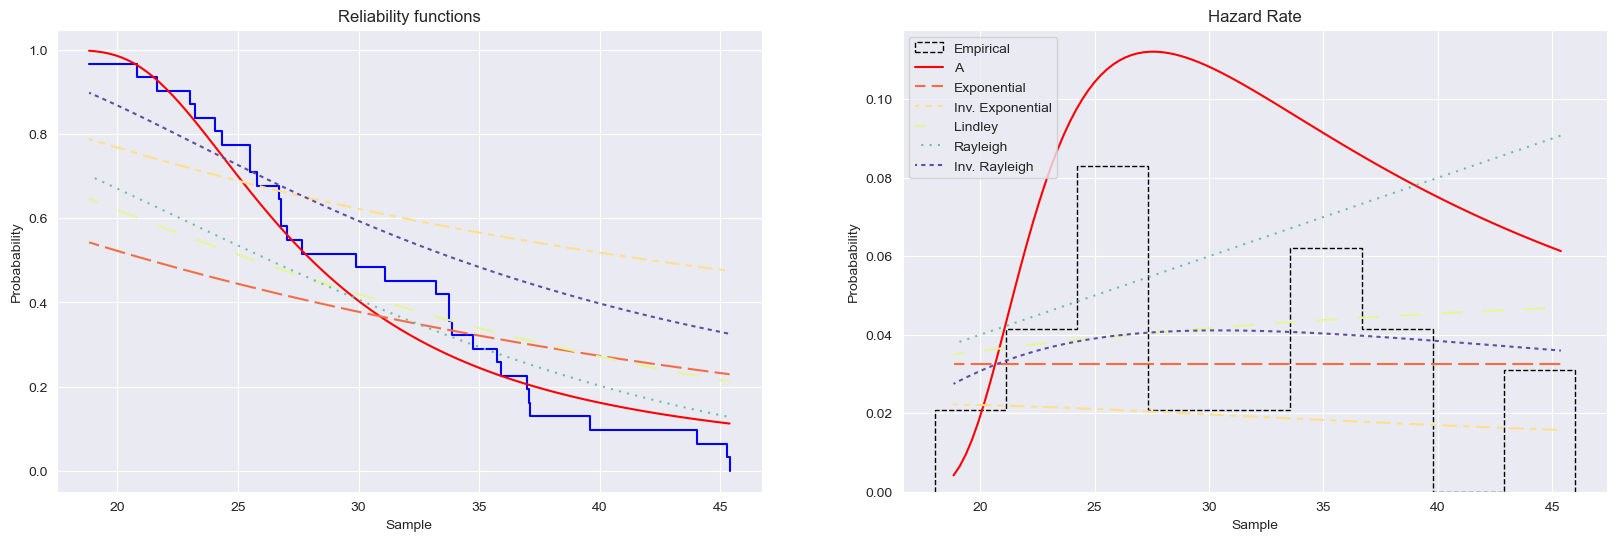

In [9]:
prob_empirica = np.arange(1, len(sample_real) + 1) / len(sample_real)
sample_space = np.linspace(min(sample_real), max(sample_real), 150)

patt = plt.get_cmap('Spectral', 6)

fig, axs = plt.subplots(1, 2, figsize = (20,6))

ax = axs[0]
ax.step(sample_real, 1 - prob_empirica, where='post',  color = 'blue', label = 'Empirical')
ax.plot(cdf_A[0], [1 - x for x in cdf_A[1]], color = 'red', label = 'A')
ax.plot(cdf_exp[0], [1 - x for x in cdf_exp[1]], ls = (5, (10, 3)), color = patt(1), label = 'Exponential')
ax.plot(cdf_invexp[0], [1 - x for x in cdf_invexp[1]], ls = (5, (7, 3, 3, 3)), color = patt(2), label = 'Inv. Exponential')
ax.plot(cdf_lind[0], [1 - x for x in cdf_lind[1]], ls = (5, (10, 10)), color = patt(3), label = 'Lindley')
ax.plot(cdf_ray[0], [1 - x for x in cdf_ray[1]], ls = (5, (1, 3)), color = patt(4), label = 'Rayleigh')
ax.plot(cdf_invray[0], [1 - x for x in cdf_invray[1]], ls = (5, (2, 2)), color = patt(5), label = 'Inv. Rayleigh')

ax.set_xlabel('Sample')
ax.set_ylabel('Probabability')
ax.set_title('Reliability functions')

ax = axs[1]

bin_edges = np.linspace(18, 46, 10)

ax.hist(sample_real, bins = bin_edges, density = True, histtype='step', edgecolor='black', linestyle='dashed', label = 'Empirical')
ax.plot(cdf_A[0], [x/(1-y) for x, y in zip(cdf_A[2], cdf_A[1])], color = 'red', label = 'A')
ax.plot(cdf_exp[0], [x/(1-y) for x, y in zip(cdf_exp[2], cdf_exp[1])], ls = (5, (10, 3)), color = patt(1), label = 'Exponential')
ax.plot(cdf_invexp[0], [x/(1-y) for x, y in zip(cdf_invexp[2], cdf_invexp[1])], ls = (5, (7, 3, 3, 3)), color = patt(2), label = 'Inv. Exponential')
ax.plot(cdf_lind[0], [x/(1-y) for x, y in zip(cdf_lind[2], cdf_lind[1])], ls = (5, (10, 10)), color = patt(3), label = 'Lindley')
ax.plot(cdf_ray[0], [x/(1-y) for x, y in zip(cdf_ray[2], cdf_ray[1])], ls = (5, (1, 3)), color = patt(4), label = 'Rayleigh')
ax.plot(cdf_invray[0], [x/(1-y) for x, y in zip(cdf_invray[2], cdf_invray[1])], ls = (5, (2, 2)), color = patt(5), label = 'Inv. Rayleigh')

ax.set_xlabel('Sample')
ax.set_ylabel('Probabability')
ax.set_title('Hazard Rate')


plt.legend()
plt.grid(True)
plt.show()

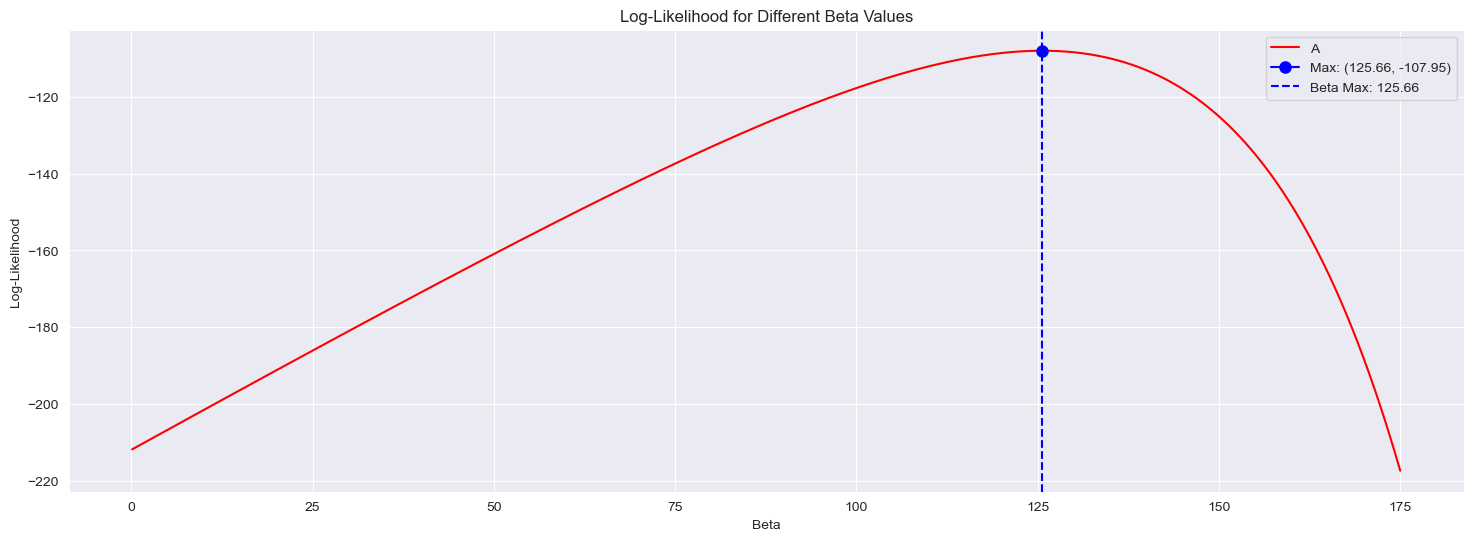

In [10]:
def LL_A(beta_hat, x_values, **kwargs):
    sum_X = sum(x**-1 for x in x_values)
    sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
    sum_ln = sum(np.log(x) for x in x_values)
    ll = (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)
    return ll


beta = np.linspace(0.1, 175, 2500)
ll_values = [LL_A(beta_hat, sample_real) for beta_hat in beta]

max_index = np.argmax(ll_values)
max_beta = beta[max_index]
max_ll = ll_values[max_index]

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax.plot(beta, ll_values, color='red', label='A')

ax.plot(max_beta, max_ll, marker='o', markersize=8, color='blue', label=f'Max: ({max_beta:.2f}, {max_ll:.2f})')
ax.axvline(x=max_beta, color='blue', linestyle='--', label=f'Beta Max: {max_beta:.2f}')

ax.set_xlabel('Beta')
ax.set_ylabel('Log-Likelihood')
ax.set_title('Log-Likelihood for Different Beta Values')
ax.legend()
plt.show()